## Model Description

This model simulates the energy balance between the Earth's surface and its atmosphere. It uses the Stefan-Boltzmann law to calculate the radiative fluxes and assumes:

- The Earth's surface is a perfect blackbody.
- The atmosphere is an imperfect blackbody with emissivity = absorptivity = Ea.
- No incoming solar radiation is absorbed by the atmosphere.
- The Earth reflects a portion of incoming solar radiation based on its albedo a. This energy leaves the system immediately without affecting the temperature.

These simplifying assumptions are useful for exploring the Earth's energy balance in a more approachable way. Here are a few notes about their accuracy and motivation:

- In reality, the energy absorbed and emitted by the atmosphere is determined by quantum interactions between photons and individual molecules, which depend on the composition of the atmosphere and the absorption cross-sections of different gases. I reduce this complexity to a single parameter Ea.
- Molecules in the atmosphere generally interact more strongly with longer wavelength radiation emitted by the earth (peak intensity ~10µm) than shorter wavelength radiation emitted by the sun (peak intensity ~500nm). However, the atmosphere does interact significantly with incoming solar radiation. For instance ozone in the atmosphere strongly absorbs longer wave UV radiation (200-360 nm).
- This model considers the Earth's surface and atmosphere to each be a single entity with uniform properties including temperature. This model does not take into account landcover or circulation within the ocean or atmosphere or variation of temperature fluxes across latitudes.

The purpose of this simulation is to understand how the temperature of the surface and atmosphere evolve over time depending on the Earth's albedo a and the emissivity of the atmosphere Ea based on the model's assumptions.

### Model Parameters and Energy Balance Equations:

In [1]:
from numpy import pi, arange
from pylab import plot, show, legend
import matplotlib.pyplot as plt

# Paramaters
sigma = 5.670374419e-8      # Stefan-BoltzmannConstant (W*m^2*K^-4)
Re = 6.3781e6               # Radius of Earth (m)
S0 = 1379                   # Solar Constant (W*m^-2)
Cs = 2.1497e23              # Heat capacity of Earth's Surface (J*K^-1)
Ca = 5.1606e21              # Heat capacity of Earth's Atmosphere (J*K^-1)
a = 0.3                     # Earth's albedo
Ea = 0.8                    # Emissivity of Earth's atmosphere

# The amount of solar energy absorbed by the earth
# a is albedo, proportion of incoming energy reflected by either the Earth's surface or the atmosphere
# S0 is the solar constant, the power of the Sun (W/m^2) at the Earth's distance from the sun
# pi*Re^2 is the area of solar energy that hits the Earth (from the Sun's perspective the Earth looks like a circle with radius Re)
def SAbs():
    return (1-a)*S0*pi*Re**2

# This is the power of radiation emitted by the blackbody, Earth's surface, as a function of temperature
def SEmit(Ts):
    return sigma*Ts**4*4*pi*Re**2

# This is the power of radiation emitted by the Earth's atmosphere, an imperfect blackbody, as a function of its temperature.
def AEmit(Ta):
    return Ea*sigma*Ta**4*4*pi*Re**2

# This is the net energy flux of the surface at any given time, the earth recieves energy from the Sun and atmosphere, and emits its own radiation.
def SNet(Ts, Ta):
    return SAbs() - SEmit(Ts) + AEmit(Ta)

# This is the net energy flux of the atmosphere at any given time. It absorbs a portion of the radiation emitted by the earth, and
# it emits energy both upwards towards space and downwards back towards the earth, which is why AEmit is multiplied by 2.
def ANet(Ts, Ta):
    return Ea*SEmit(Ts) - 2*AEmit(Ta)

# Derivative of surface temperature wrt time
def dTSdt(Ts, Ta):
    return SNet(Ts,Ta)/Cs

# Derivative of atmospheric temperature wrt time
def dTAdt(Ts, Ta):
    return ANet(Ts,Ta)/Ca

### Simulation Demonstration

As an initial demonstration of this model, set both the atmosphere and surface to 0 degrees C and observe how the system evolves over time:

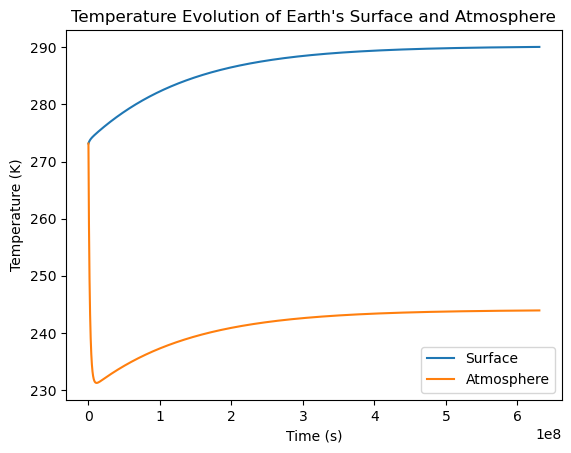

In [2]:
t0 = 0                        # Initial time
dt = 864                      # Timestep (s); 0.01 days in this case
tf = 3600*24*365*20           # Final time (s); 20 years in this case
tlist = arange(t0, tf, dt)

# Initial temperatures (set to 0 degrees C)
Ta = 273.15                   # Initial atmospheric temp (K)
Ts = 273.15                   # Initial surface temp (K)

# Lists of atmospheric and surface temperatures
TaList = []
TsList = []

for t in tlist:
    TaList.append(Ta)
    TsList.append(Ts)
    
    # Second order Range-Kutta
    tmid = t + dt/2
    tsmid = Ts + dt/2*dTSdt(Ts, Ta)
    tamid = Ta + dt/2*dTAdt(Ts, Ta)
    Ts += dt*dTSdt(tsmid, tamid)
    Ta += dt*dTAdt(tsmid, tamid)

    
    t += dt
    
plt.plot(tlist, TsList, label="Surface")
plt.plot(tlist, TaList, label="Atmosphere")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.legend()
plt.title("Temperature Evolution of Earth's Surface and Atmosphere")
plt.show()

The values used so far for albedo (0.3) and atmospheric absorptivity/emissivity (0.8) are approximations used to create a realistic model. However, humans have changed the composition of the atmosphere, so these values are subject to change. CO2 absorbs radiation emitted by the Earth at high rates, and so increasing the concentration of CO2 in the atmosphere effectively increases atmospheric absorptivity/emissivity. 

One common geoengineering proposal to counteract the negative effects of climate change is to intentionally emit sulfate aerosols into the stratosphere. These aerosols reflect shortwave radiation incoming from the sun, but do not significantly interact with outgoing shortwave radiation leaving the earth. Therefore, these aerosols increase the Earth's albedo without having a significant affect on absorptivity.

### Equilibrium Temperatures

Next, let's examine how the equilibrium temperatures of the surface and atmosphere are effected by changing the albedo and emissivity, by setting the temperature derivatives equal to 0.

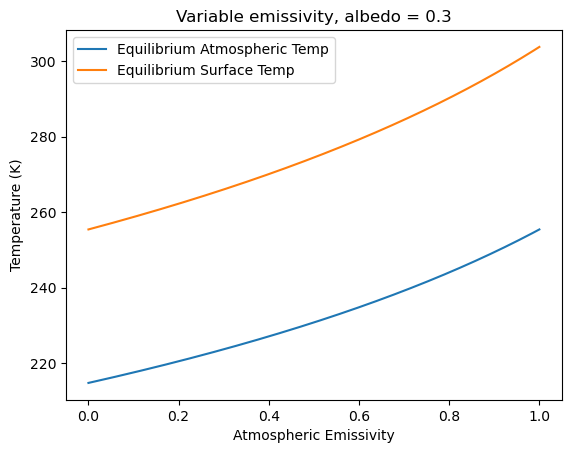

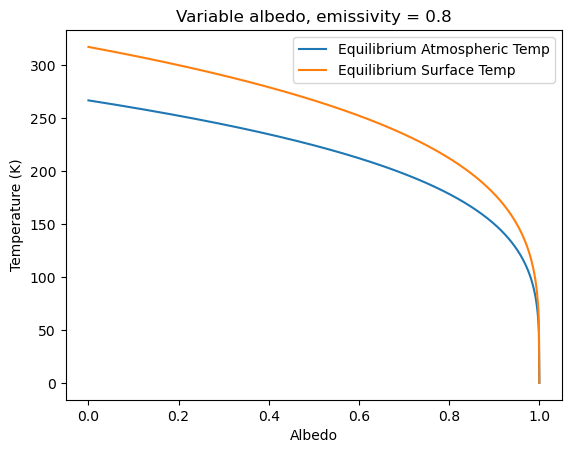

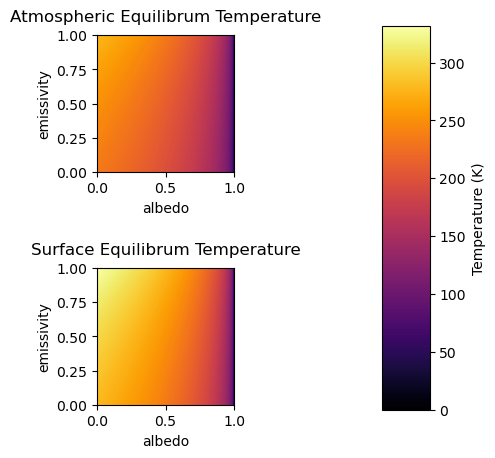

In [3]:
from numpy import zeros, linspace
from pylab import xlabel, ylabel, imshow, colorbar, title, subplot, subplots_adjust, axes

# Set the temperature derivatives equal to 0 in order to find a system of two equations for steady-state temperatures
# Solve these equations for Ts and Ta as functions of e and a
def Temps(e, a):
    Ta = ((S0*pi*Re**2/Cs)*(1-a)/((sigma*4*pi*Re**2/Cs)*(2-e)))**(1/4)
    Ts = (2*Ta**4)**(1/4)
    return Ta, Ts

N = 1000
Ea = linspace(0,1,N)  # List of emissivity values ranging from 0 to 1

# Lists for the equilibrium temperature of the atmosphere/surface at varying emissivity values
ETAe = []
ETSe = []

for e in Ea:
    Ta, Ts = Temps(e, 0.3) # note we are holding albedo constant at 0.3
    ETAe.append(Ta)
    ETSe.append(Ts)
    
a = linspace(0,1,N) # List of albedo values ranging from 0 to 1
ETAa = []
ETSa = []

for alb in a:
    Ta, Ts = Temps(0.8, alb) # Note we are holding emissivity constant at 0.8
    ETAa.append(Ta)
    ETSa.append(Ts)
    
xlabel("Atmospheric Emissivity")
ylabel("Temperature (K)")
title("Variable emissivity, albedo = 0.3")
plot(Ea, ETAe, label = "Equilibrium Atmospheric Temp")
plot(Ea, ETSe, label = "Equilibrium Surface Temp")
legend()
show()

xlabel("Albedo")
ylabel("Temperature (K)")
title("Variable albedo, emissivity = 0.8")
plot(a, ETAa, label = "Equilibrium Atmospheric Temp")
plot(a, ETSa, label = "Equilibrium Surface Temp")
legend()
show()

ETS = zeros([N, N], float)
ETA = zeros([N, N], float)
x = 0
y = 0
for alb in a: 
    x = 0
    for e in Ea:
        Ta, Ts = Temps(e, alb)
        ETS[x, y] = Ts
        ETA[x, y] = Ta
        x += 1
    y +=1
  
subplot(211)
imshow(ETA, origin = "lower", extent = [0, 1, 0, 1], cmap = "inferno", vmax = 332)
xlabel("albedo")
ylabel("emissivity")
title("Atmospheric Equilibrum Temperature", pad = 10)
subplot(212)
imshow(ETS, origin = "lower", extent = [0, 1, 0, 1], cmap = "inferno", vmax = 332)
xlabel("albedo")
ylabel("emissivity")
title("Surface Equilibrum Temperature", pad = 10)
subplots_adjust(hspace = 0.7)
cax = axes([0.85, 0.1, 0.075, 0.8])
colorbar(label="Temperature (K)", cax = cax)
show()

From these graphs, we can observe that increasing emissivity increases equilibrium temperatures, and increasing albedo decreases equilibrium temperatures. If the Earth reflected all incoming radiation, its equilibrium temperature would be absolute 0. 

### Emissivity, CO2, and Climate Change

By relating emissivity/absorptivity to CO2 in the atmosphere we can observe how temperatures change as a result of CO2 emissions.

The Intergovernmental Panel on Climate Change has adopted several "Representative Concentration Pathways" each of which represents a different possible scenario of human response to climate change. CO2 concentrations over time have been calculated for these RCPs:
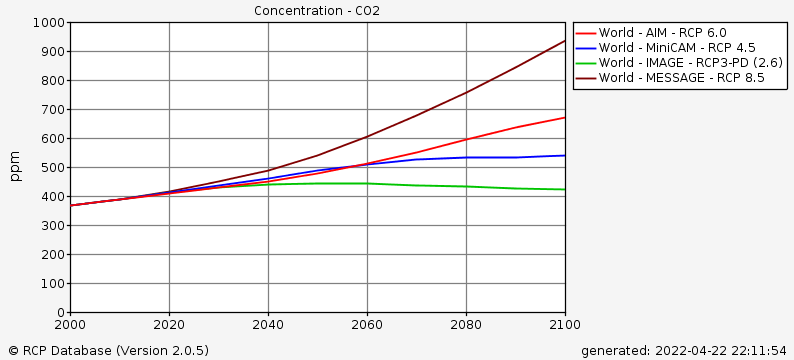

Image source: https://tntcat.iiasa.ac.at/RcpDb/dsd?Action=htmlpage&page=compare

Our simple model can be used to determine a rough estimate of how temperature changes in each of these scenarios by defining a function which relates CO2 concentration to atmospheric emissivity:

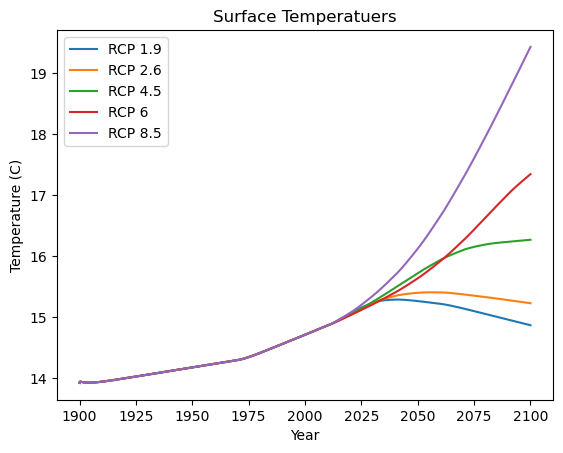

In [5]:
from numpy import tanh, array, zeros

# These functions are modified so that energy fluxes are also dependent on the CO2 concentration in the atmosphere, which is
# used to calculate a changing atmospheric emissivity/absorptivity
def dTSdt(Ts, Ta, C):
    return SNet(Ts,Ta, C)/Cs

def dTAdt(Ts, Ta, C):
    return ANet(Ts,Ta, C)/Ca

def SAbs():
    return (1-a)*S0*pi*Re**2

def SEmit(Ts):
    return sigma*Ts**4*4*pi*Re**2

def SNet(Ts, Ta, C):
    return SAbs() - SEmit(Ts) + AEmit(Ta, C)

def AEmit(Ta, C):
    return e(C)*sigma*Ta**4*4*pi*Re**2

def ANet(Ts, Ta, C):
    return e(C)*SEmit(Ts) - 2*AEmit(Ta, C)

"""
This function calculates emissivity/absorptivity of the atmosphere as a function of CO2 concentration.
This function was determined semi-arbitrarily with a few determined constraints:
* A paper I saw that said that CO2 contributes about 0.1 to atmospheric emissivity, providing the point (0, 0.7). 
* (280, 0.746) gives the correct equilbrium pre-industrial surface temperature with albedo = 0.3.
* Emissivity <= 1 
"""
def e(C):
    return 0.3*tanh(C/1800)+0.7

# This function takes a list of times, and a list of CO2 concentrations at those times and calculates how the atmospheric, and
# surface temperatures change between the initial and final time
def RCPSim(tlist, clist):
    SSPTaList = []
    SSPTsList = []
    t = tlist[0]
    C = clist[0]
    Tss = Tsi
    Tas = Tai    
    for tf in range(len(tlist)-1):
        dC = (clist[tf+1] - clist[tf])/((tlist[tf+1]-tlist[tf])/dt)
        while t < tlist[tf+1]:
            SSPTaList.append(Tas)
            SSPTsList.append(Tss)
    
            tsmid = Tss + dt/2*dTSdt(Tss, Tas, C)
            tamid = Tas + dt/2*dTAdt(Tss, Tas, C)
            Tss += dt*dTSdt(tsmid, tamid, C)
            Tas += dt*dTAdt(tsmid, tamid, C)
            t += dt
            C += dC
    return SSPTaList, SSPTsList

# Calculates the number of seconds in y years
def sec(y):
    return y*3600*24*365

# Switch to using pre-industrial equilibria temperatures as initial conditions
a = 0.3
Tai = 243.4      # Initial atmospheric temp (K)
Tsi = 287.07     # Initial surface temp (K)

dt = 3600*24     # Use a larger time step since we have a large number of computations

# RCP Scenarios: t=0 represents 1900 
RCPtList = [0,sec(70),sec(110),sec(120),sec(130),sec(140),sec(150),sec(160),sec(170),sec(180),sec(190),sec(200)]
RCP19cList = [280, 325, 390, 415, 430, 430, 425, 420, 410, 400, 390, 380]
RCP26cList = [280, 325, 390, 412, 431, 440, 443, 442, 437, 432, 426, 421]
RCP45cList = [280, 325, 390, 411, 435, 461, 487, 509, 524, 531, 534, 538]
RCP6cList =  [280, 325, 390, 409, 429, 451, 478, 511, 550, 594, 636, 670]
RCP85cList = [280, 325, 390, 416, 449, 489, 541, 604, 677, 758, 845, 936]

tlist = arange(0,sec(200),dt)
RCP85Ta, RCP85Ts = RCPSim(RCPtList,RCP85cList)
RCP6Ta, RCP6Ts = RCPSim(RCPtList, RCP6cList)
RCP45Ta, RCP45Ts = RCPSim(RCPtList, RCP45cList)
RCP26Ta, RCP26Ts = RCPSim(RCPtList, RCP26cList)
RCP19Ta, RCP19Ts = RCPSim(RCPtList, RCP19cList)

# Convert from sec to calendar year
tplotlist = (tlist/(3600*24*365))+1900

# Convert from K to Celsius
RCP85Ts[:] = [i - 273.15 for i in RCP85Ts]
RCP6Ts[:] = [i - 273.15 for i in RCP6Ts]
RCP45Ts[:] = [i - 273.15 for i in RCP45Ts]
RCP26Ts[:] = [i - 273.15 for i in RCP26Ts]
RCP19Ts[:] = [i - 273.15 for i in RCP19Ts]

plot(tplotlist, RCP19Ts, label = "RCP 1.9")
plot(tplotlist, RCP26Ts, label = "RCP 2.6")
plot(tplotlist, RCP45Ts, label = "RCP 4.5")
plot(tplotlist, RCP6Ts, label = "RCP 6")
plot(tplotlist, RCP85Ts, label = "RCP 8.5")
legend()
title("Surface Temperatuers")
xlabel("Year")
ylabel("Temperature (C)")
show()

Compared to official estimates, this model slightly underestimates the impact that small changes in CO2 concentration have on global temperatures, and overestimates the impact that large changes have. Official sources estimate that the RCP 8.5 scenario would lead to 4.3 degrees of warming compared to pre-industrial temperatures by the end of the century. This model shows about 5.5 degrees of warming under that scenario. The RCP1.9 scenario should lead to about 1.5 degrees of warming, however, this model shows about 1 degree of warming. 

### Model Extension: Multi-layered Atmosphere

There are a few ways I wanted to increase the complexity of this program to improve its accuracy. One idea was to split the atmosphere into multiple layers: the troposphere, stratosphere, mesosphere, thermosphere, and exosphere. In reality, temperature varies widely within these layers. However, they are defined as they are because there is less circulation between these layers than there is within them. 

Now I present the simulation results with the division of the atmosphere into different layers.

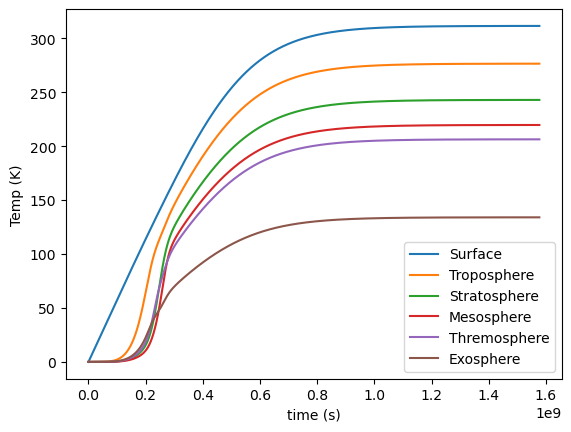

In [7]:
from numpy import pi, arange, array, e, zeros, prod
from pylab import plot, show, xlabel, ylabel, legend

# Function for debugging
def print_energy_values(step, Ts, Ta, SE, AE, IE, SNet, ANet):
    print(f"Step: {step}")
    print(f"Surface Temperature: {Ts}")
    print(f"Atmospheric Temperatures: {Ta}")
    print(f"Surface Emitted Energy: {SE}")
    print(f"Atmospheric Emitted Energy: {AE}")
    print(f"Incoming Energy to Layers: {IE}")
    print(f"Net Surface Energy: {SNet}")
    print(f"Net Atmospheric Energy: {ANet}")
    print("-" * 40)

# Paramaters
sigma = 5.670374419e-8      # Stefan-BoltzmannConstant (W*m^2*K^-4)
Re = 6.3781e6               # Radius of Earth (m)
G = 6.6743e-11              # Gravitational constant (N*m^2*kg^-2)
Me = 5.97219e24             # Mass of earth (kg)
S0 = 1379                   # Solar Constant (W*m^-2)
Cs = 2.1497e23              # Heat capacity of Earth's Surface (J*K^-1)
a = 0.3                     # Earth's albedo
Es = 1                      # Emissivity of Earth's surface
Ea = array([0.8, 0.6, 0.2, 0.01, 1e-8], float)          # Emissivity of Earth's atmospheric layers
ha = array([12000, 50000, 80000, 550000, 1e7], float)  # upper height of atmospheric layer (m)

# Derivative of surface temperature wrt time
def dTSdt(Ts, Ta):
    return SNet(Ts,Ta)/Cs

# Derivative of atmospheric temperature wrt time
# In this case Ta is an array of atmospheric temperatures, it returns an array.
def dTAdt(Ts, Ta):
    return ANet(Ts,Ta)/Ca

# This calculates the energy incoming to each atmospheric layer. Here I hardcoded it, so it will only work with a 5 layer 
# atmosphere. It takes an array Ta of atmospheric temperature values, and returns an array of the energy incoming to each of 
# the 5 layers of the atmosphere.
# I intended to write a version of this function that would work for an arbitrary number of atmospheric layers, 
# but I never needed it, so I never got around to debugging it.
def IncomingEnergy(Ts, Ta):
    n = len(Ea)
    IE = zeros(n, float)
    SE = SEmit(Ts)
    AE = AEmit(Ta, Ea, ha)
    
    for i in range(n):
        incoming_energy = 0
        
        # Sum of emissions from all other layers modified by emissivities
        for j in range(n):
            if j != i:
                attenuation = 1
                for k in range(min(i, j), max(i, j)):
                    if k != i and k != j:
                        attenuation *= (1 - Ea[k])
                incoming_energy += AE[j] * attenuation
        
        # Adding source emission for layer 0 and adjusted source emission for other layers
        if i == 0:
            IE[i] = Ea[i] * (SE + incoming_energy)
        else:
            attenuation = prod(1 - Ea[:i])
            IE[i] = Ea[i] * (incoming_energy + SE * attenuation)

    if sum(IE) > SE + 2 * sum(AE):
        raise ValueError('Conservation of Energy Problem')

    return IE

# Calculates the total energy emitted by any part of the atmosphere that reaches the surface
# Takes an array of temperature values Ta and returns the energy flux reaching the surface in Watts
# cea is a coefficient 0-1 representing "cumulative energy absorbed" representing the amount of energy that reaches the surface 
    # (i.e. is not absorbed by another layer of the atmosphere)
def AtmS(Ta):
    cea = 1  # Cumulative energy absorbed coefficient
    E = 0    # Total energy reaching the surface
    for i in range(len(Ta)):
        emitted_energy = AEmit(Ta[i], Ea[i], ha[i])
        E += cea * emitted_energy
        cea *= (1 - Ea[i])  # Update attenuation factor for the next layer
    return E

# Same as it was defined before
def SAbs():
    return Es*(1-a)*S0*pi*Re**2

# Same as defined before
def SEmit(Ts):
    return Es*sigma*Ts**4*4*pi*Re**2

# Uses the function AtmS to find energy coming to the surface from the atmosphere instead of AEmit
def SNet(Ts, Ta):
    return SAbs() - SEmit(Ts) + AtmS(Ta)

# Calculates the amount of radiation leaving a layer of the atmosphere, taking an array of temperature values T, emissivity 
# values e, and height values h. This is the amount of power (W) emitted both upwards and downwards.
# Can be used for all layers simultaneously (as when it is called as a helper in ANet) or for a single layer (as when it is
# called in AtmS()).
# In the two box model, the area of contact between the earth and the atmosphere was the same as the surface area of the earth
# however, in this case higher atmospheric layers have larger surface areas in contact with the layers above them, 
# which is why I take h into account. This is potentially negligible in practice.
def AEmit(T, e, h):
    return e*sigma*T**4*4*pi*(Re+h)**2

# Uses the incoming energy function to find the energy entering each layer and the AEmit function to find the energy
# leaving each layer. 
def ANet(Ts, Ta):
    return IncomingEnergy(Ts, Ta) - 2*AEmit(Ta, Ea, ha)

# Atmospheric pressure as a function of height. This function comes from the following website:
# https://www.grc.nasa.gov/WWW/K-12/rocket/atmos.html#:~:text=As%20we%20increase%20altitude%20through,decreases%20as%20we%20increase%20altitude.
# I use this function to calculate the mass of each atmospheric layer, which is needed to calculate the heat capacity. I could 
# not find this information anywhere online.
# This is a continuous piecewise function
def APres(h):
    if h < 36152:
        T = 59 - 0.00356*h
        return 47.88*2116*((T+459.7)/518.6)**5.256
    elif h < 82345:
        return 47.88*473.1*e**(1.73 - 0.000048*h)
    else:
        T = -205.05 + (0.00164)*h
        return 47.88*51.97*((T+459.7)/389.98)**(-11.388)

# Gravity of the earth as a function of height (m/s^2). Used in calculating the masses of the atmospheric layers.
# This is most likely negligible, and using a constant of 9.81 would yield similar results.
def g(h):
    return G*Me/(Re+h)**2

# This effectively is the derivative of a function which gives the mass of the atmosphere up to height h
# This can be thought of as the "atmposhperic mass gradient" 
def mass(h):
    return APres(h)*SArea(h)/g(h)

# This calculates the surface area of an atmospheric layer at height h
def SArea(h):
    return 4*pi*(Re+h)**2

# This calculates the mass of the atmosphere between height h1 and height h2 by integrating the atmposhperic mass gradient.
def aMass(h1, h2):
    N = 10000 
    dh = (h2-h1)/N
    I = dh/2*(mass(h1) + mass(h2))        # initialize value of integral
    for k in range(1, N):
        I += dh*mass(h1+k*dh)
    return I/(h2-h1)

# Creating an array of masses for the various atmospheric layers
ma = array([0,0,0,0,0], float)
ma[0] = aMass(0, ha[1])                                 
for i in range(1, len(ha)):
    ma[i] = aMass(ha[i-1], ha[i])
    
Ca = ma*1003                  # Heat capacity array for the atmospheric layers.

t0 = 0
dt = 864                      # Timestep (s)
tf = 3600*24*365*50            # Length of simulation
tlist = arange(t0, tf, dt)    # Array of time values

Ti = 0
Tatm = array([0, 0, 0, 0, 0], float) # Initial atmospheric temp (K)
Tsurf = Ti                                # Initial surface temp (K)

# Lists holding temperture values over time
Ta0List = []
Ta1List = []
Ta2List = []
Ta3List = []
Ta4List = []
TsList = []

for step, t in enumerate(tlist):
    Ta0List.append(Tatm[0])
    Ta1List.append(Tatm[1])
    Ta2List.append(Tatm[2])
    Ta3List.append(Tatm[3])
    Ta4List.append(Tatm[4])
    TsList.append(Tsurf)
    
    SE = SEmit(Tsurf)
    AE = AEmit(Tatm, Ea, ha)
    IE = IncomingEnergy(Tsurf, Tatm)
    SNet_val = SNet(Tsurf, Tatm)
    ANet_val = ANet(Tsurf, Tatm)
    ''' # Used for debugging
    if step % 10000 == 0:
        print_energy_values(step, Tsurf, Tatm, SE, AE, IE, SNet_val, ANet_val)
    '''
    
    Tsurf += dt * dTSdt(Tsurf, Tatm)
    Tatm += dt * dTAdt(Tsurf, Tatm)
    
plot(tlist, TsList, label = "Surface")
plot(tlist, Ta0List, label = "Troposphere")
plot(tlist, Ta1List, label = "Stratosphere")
plot(tlist, Ta2List, label = "Mesosphere")
plot(tlist, Ta3List, label = "Thremosphere")
plot(tlist, Ta4List, label = "Exosphere")
xlabel("time (s)")
ylabel("Temp (K)")
legend()
show()

Temperature decreases in each higher atmospheric layer, which is to be expected. 

In reality the thermosphere is hotter than lower layers (hence the name). This is due to interaction of the atmosphere with incoming solar radiation which is still not captured in this model. 

Note that the values of emissivity/absorptivity must be carefully chosen based on the heat capacity of each layer. If absorptivity is too high relative to the heat capacity and time step dt, the simulation becomes unstable due to large fluctuations in temperature over a single timestep. However, in reality absorptivity and heat capacity would indeed be related as both are dependent on the total amount of air in a layer (heat capacity is proportional to mass, and absorptivity will be affected by the number of molecules which may interact with photons). 

## Conclusion

This project has explored the energy balance between the Earth's surface and its atmosphere using a simplified model. While this model makes several simplifying assumptions, it serves as a valuable educational tool. These simplifications allow us to focus on the basic principles of radiative flux and temperature evolution, providing a foundational understanding of how the Earth's energy balance is influenced by factors such as albedo and atmospheric emissivity. Understanding how these factors influence the equilibrium temperatures of the surface and atmosphere provide an elementry understanding of how the actions of humans can affect the climate.

The deviation of our model from reality highlights the complexity of atmospheric interactions and the importance of considering detailed atmospheric composition and behavior in more advanced studies. Modern climate models incorporate a wide range of physical, chemical, and biological processes to simulate the Earth's climate system. These models account for the interactions between the atmosphere, oceans, land surface, and ice, using sophisticated algorithms to represent processes such as cloud formation, greenhouse gas dynamics, and ocean circulation.

Overall, this project illustrates at a basic level how physical principles contribute climate science and provides a stepping stone for more sophisticated modeling efforts. Through increasingly sophisticated modeling, we deepen our understanding of climate dynamics and improve our ability to predict and respond to changes in the Earth's climate system.